In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

In [154]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 0. Полезные функции

In [155]:
def isnan(value):
    return value is None or value != value

In [156]:
def analyze(series, categorical: bool = None):
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:, 0]

    series_unique = sorted(series.unique())

    if categorical is None:
        categorical = len(series_unique) < 30

    max_len = 10

    print(
        f"unique: {len(series_unique)}",
        f"empty: {sum([isnan(el) for el in series])}",
        f"filled: {sum([not isnan(el) for el in series])},",
        f"values: {list(series_unique[:max_len]) + [] if len(series_unique) < max_len else ['...']}" if categorical else ""
    )
    if categorical:
        for val in series_unique[:max_len]:
            if isnan(val):
                print(f"{val} - {sum(series.isna())} times")
            else:
                print(f"{val} - {sum(series == val)} times")
        if len(series_unique) < 30:
            series.hist(xrot=-30)
    else:
        print(f"min: {series.min()}, mean: {series.mean()}, max: {series.max()}, std: {series.std()}")
        series.hist()
    plt.show()

# 1. Загрузка данных

In [609]:
df = pd.read_excel('dataset.xlsx')
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier,mean_economy_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3460071768,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,['ХозОбор'],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05,0.000000,0.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7704543951,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,['МедОбор'],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05,0.000000,0.000000
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,610601634808,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,['ХозМат'],ХозМат,0.0,0.000000,44,11,0.250000,11,1.000000,4,1.272727,4954000.00,4.503636e+05,0.000000,0.000000
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6671095570,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,['МедМат'],МедМат,0.0,0.000000,13,11,0.846154,11,1.000000,4,1.727273,6555490.00,5.959536e+05,0.000000,0.000000
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7726460307,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,['МедМат'],МедМат,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,499850.00,4.998500e+05,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5321065111,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"['ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги']",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05,0.000000,0.000000
2671,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6660139553,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"['МедМат', 'ХозМат']",МедМат,0.0,0.000000,8,5,0.625000,6,0.833333,3,1.800000,2168562.02,4.337124e+05,0.000000,0.000000
2672,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7207006570,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,['Другое'],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06,0.000000,0.000000
2673,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,463001373948,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,['МедМат'],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,97280

# 2. Собираем выборку поставщик-заказчик с рассчитанными признаками

In [610]:
print(list(df.columns))

['contract_guid', 'contract_is_complete', 'contract_extension', 'purchase_type_code', 'notice_lot_max_contract_price', 'notice_lot_initial_sum', 'region_name', 'notice_lot_currency_code', 'supplier_inn', 'supplier_type', 'contract_placer_inn', 'contract_rub_price', 'contract_price', 'contract_start_execution_date', 'contract_end_execution_date', 'contracts_for_lot', 'contract_positions_count', 'lot_guid', 'real_rub_price', 'real_initial_sum', 'position_category', 'contract_category', 'economy', 'economy_percent', 'total_placer_contracts', 'total_placer_with_supplier_contracts', 'percent_placer_with_supplier_contracts', 'total_supplier_contracts', 'percent_supplier_with_placer_contracts', 'max_contract_positions_placer_supplier', 'mean_contract_positions_placer_supplier', 'total_contract_sum_placer_supplier', 'mean_contract_sum_placer_supplier', 'min_economy_placer_supplier', 'mean_economy_placer_supplier']


##### Рассчитанные признаки

In [611]:
calculated_features = [
    'mean_economy_placer_supplier',  # средняя экономия по лоту для пары
    'min_economy_placer_supplier',  # минимальная экономия по лоту для пары
    'mean_contract_sum_placer_supplier',  # средняя сумма договоров между заказчиком и поставщиком
    'total_contract_sum_placer_supplier',  # общая сумма договоров между заказчиком и поставщиком
    'mean_contract_positions_placer_supplier',  # среднее количество позиций в договоре для пары
    'max_contract_positions_placer_supplier',  # максимальное количество позиций в договоре для пары
    'percent_placer_with_supplier_contracts',  # процент договоров, которые заказчик заключил с этим поставщиком
    'percent_supplier_with_placer_contracts'  # процент договоров, которые поставщик заключил с этим заказчиком
]

df[calculated_features]

,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,0.000000,0.000000,2.435700e+05,243570.00,1.000000,1,0.250000,1.000000
1,0.000000,0.000000,5.145375e+05,5145375.13,1.600000,3,0.416667,0.370370
2,0.000000,0.000000,4.503636e+05,4954000.00,1.272727,4,0.250000,1.000000
3,0.000000,0.000000,5.959536e+05,6555490.00,1.727273,4,0.846154,1.000000
4,0.000000,0.000000,4.998500e+05,499850.00,1.000000,1,0.250000,1.000000
...,...,...,...,...,...,...,...,...
2670,0.000000,0.000000,9.749975e+05,974997.49,7.000000,7,1.000000,1.000000
2671,0.000000,0.000000,4.337124e+05,2168562.02,1.800000,3,0.625000,0.833333
2672,0.000000,0.000000,2.208919e+06,2208918.60,1.000000,1,0.035714,1.000000
2673,-0.122583,-0.247667,4.864000e+05,972800.00,1.000000,1,1.000000,1.000000


In [612]:
supplier_placer = ['supplier_inn', 'contract_placer_inn']
df['supplier_inn'] = df.apply(
    lambda row: str(row['supplier_inn']),
    axis=1
)
df['contract_placer_inn'] = df.apply(
    lambda row: str(row['contract_placer_inn']),
    axis=1
)
df = df[supplier_placer + calculated_features].drop_duplicates()
df

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,3460071768,3821005886,0.0,0.0,2.435700e+05,243570.00,1.000000,1,0.250000,1.00000
1,7704543951,3525147496,0.0,0.0,5.145375e+05,5145375.13,1.600000,3,0.416667,0.37037
2,610601634808,6152000366,0.0,0.0,4.503636e+05,4954000.00,1.272727,4,0.250000,1.00000
3,6671095570,6623050480,0.0,0.0,5.959536e+05,6555490.00,1.727273,4,0.846154,1.00000
4,7726460307,7709125605,0.0,0.0,4.998500e+05,499850.00,1.000000,1,0.250000,1.00000
...,...,...,...,...,...,...,...,...,...,...
2667,7728024000,7224009059,0.0,0.0,4.160000e+05,416000.00,1.000000,1,0.011236,1.00000
2668,7705910160,7725009701,0.0,0.0,5.000000e+05,500000.00,1.000000,1,1.000000,1.00000
2669,3019022395,3018010781,0.0,0.0,1.417920e+05,141792.00,1.000000,1,0.500000,1.00000
2670,5321065111,7802312751,0.0,0.0,9.749975e+05,974997.49,7.000000,7,1.000000,1.00000


# 3. Анализ признаков и удаление выбросов

In [644]:
dataset = df

In [645]:
print(list(dataset.columns))

['supplier_inn', 'contract_placer_inn', 'mean_economy_placer_supplier', 'min_economy_placer_supplier', 'mean_contract_sum_placer_supplier', 'total_contract_sum_placer_supplier', 'mean_contract_positions_placer_supplier', 'max_contract_positions_placer_supplier', 'percent_placer_with_supplier_contracts', 'percent_supplier_with_placer_contracts']


### Средняя экономия по лоту для пары

unique: 314 empty: 0 filled: 1498, 
min: -86.06770029673591, mean: -0.24859546884226294, max: 0.872799, std: 4.649876909149694


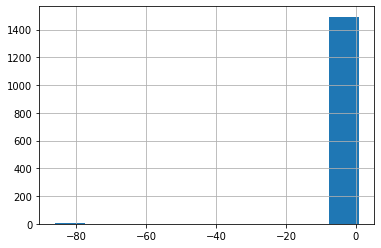

In [646]:
analyze(dataset['mean_economy_placer_supplier'])

### Минимальная экономия по лоту для пары

unique: 273 empty: 0 filled: 1498, 
min: -86.06770029673591, mean: -0.25739885140808544, max: 0.872799, std: 4.649995580143172


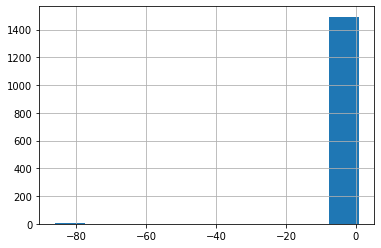

In [647]:
analyze(dataset['min_economy_placer_supplier'])

##### удаляем слишком большую экономию

In [648]:
dataset[dataset['min_economy_placer_supplier'] > 0.4]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
27,6678088719,6608001915,0.436215,0.436215,1978413.04,1978413.04,23.0,23,0.500000,1.000000
265,5256140020,5260136299,0.730769,0.730769,4200000.00,4200000.00,1.0,1,0.250000,1.000000
315,780442866910,7202010269,0.459990,0.459990,549880.00,549880.00,8.0,8,0.500000,1.000000
354,7701755549,7729101120,0.835620,0.750440,161390.00,322780.00,2.0,2,0.032258,1.000000
430,7728313442,7727560086,0.800000,0.800000,7968000.00,7968000.00,1.0,1,1.000000,1.000000
493,7710026574,7722019652,0.595100,0.595100,357392.00,357392.00,1.0,1,1.000000,1.000000
498,9717071570,7726747370,0.613260,0.613260,764563.80,764563.80,1.0,1,0.333333,1.000000
548,7714511476,7729101120,0.601000,0.601000,199500.00,199500.00,1.0,1,0.016129,0.200000
559,7710258600,7729101120,0.733325,0.698104,133337.40,266674.80,1.0,1,0.032258,1.000000
598,7203418646,5406695419,0.612750,0.612750,387250.00,387250.00,1.0,1,1.000000,1.000000


In [649]:
dataset = dataset[dataset['min_economy_placer_supplier'] <= 0.4]


##### удаляем слишком маленькую экономию

In [650]:
dataset[dataset['min_economy_placer_supplier'] < -0.2]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
17,616511897803,6152000366,-0.040000,-0.666667,1.565520e+05,2.348280e+06,1.000000,1,0.340909,1.000000
28,4634010140,4632060153,-0.169607,-0.508820,3.348882e+06,1.004664e+07,1.000000,1,1.000000,1.000000
192,1435242720,8905026850,-0.722980,-0.722980,7.020806e+06,7.020806e+06,1.000000,1,0.142857,1.000000
215,5017112368,3443012297,-0.166667,-1.000000,3.540612e+07,4.248734e+08,1.166667,2,0.240000,1.000000
248,7325019247,7328014430,-0.375000,-0.950000,7.731215e+05,1.546243e+06,1.000000,1,0.062500,1.000000
343,7326024095,7328041152,-0.627158,-1.254316,2.452407e+05,9.809629e+05,7.500000,11,1.000000,1.000000
410,7715986384,7705709543,-85.409200,-85.409200,6.364089e+05,6.364089e+05,1.000000,1,0.166667,1.000000
448,7842002467,2709001590,-73.357691,-73.357691,6.581897e+05,6.581897e+05,2.000000,2,0.500000,1.000000
519,7726625380,4214000252,-85.250000,-85.250000,1.463159e+06,1.463159e+06,1.000000,1,0.333333,1.000000
633,6234166228,5260200603,-0.800000,-1.000000,7.908680e+05,3.954340e+06,1.000000,1,0.333333,1.000000


In [651]:
dataset = dataset[dataset['min_economy_placer_supplier'] >= -0.2]

##### удаляем нулевую экономию, так как она ничего не дает для анализа

In [652]:
dataset[dataset['min_economy_placer_supplier'] == 0]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,3460071768,3821005886,0.0,0.0,2.435700e+05,243570.00,1.000000,1,0.250000,1.00000
1,7704543951,3525147496,0.0,0.0,5.145375e+05,5145375.13,1.600000,3,0.416667,0.37037
2,610601634808,6152000366,0.0,0.0,4.503636e+05,4954000.00,1.272727,4,0.250000,1.00000
3,6671095570,6623050480,0.0,0.0,5.959536e+05,6555490.00,1.727273,4,0.846154,1.00000
4,7726460307,7709125605,0.0,0.0,4.998500e+05,499850.00,1.000000,1,0.250000,1.00000
...,...,...,...,...,...,...,...,...,...,...
2667,7728024000,7224009059,0.0,0.0,4.160000e+05,416000.00,1.000000,1,0.011236,1.00000
2668,7705910160,7725009701,0.0,0.0,5.000000e+05,500000.00,1.000000,1,1.000000,1.00000
2669,3019022395,3018010781,0.0,0.0,1.417920e+05,141792.00,1.000000,1,0.500000,1.00000
2670,5321065111,7802312751,0.0,0.0,9.749975e+05,974997.49,7.000000,7,1.000000,1.00000


In [653]:
delete_zero_economy = False
if delete_zero_economy:
    dataset = dataset[dataset['min_economy_placer_supplier'] != 0]

### Средняя сумма договоров между заказчиком и поставщиком

unique: 1304 empty: 0 filled: 1436, 
min: 0.01, mean: 3451507.4705227, max: 856359493.82, std: 33043502.34198636


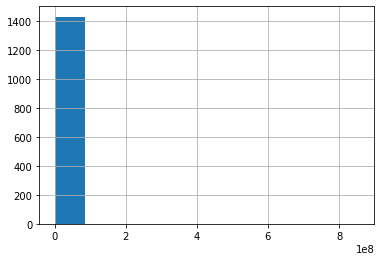

In [654]:
analyze(dataset['mean_contract_sum_placer_supplier'])

In [655]:
dataset[dataset['mean_contract_sum_placer_supplier'] > 10000000]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
40,6685094329,6608001915,0.000000e+00,0.000000e+00,1.696499e+07,1.696499e+07,1.000000,1,0.500000,1.000000
59,7802684816,7838041248,0.000000e+00,0.000000e+00,1.637367e+07,4.912100e+07,1.000000,1,0.200000,1.000000
98,3305795861,3325008103,0.000000e+00,0.000000e+00,5.152500e+07,1.545750e+08,1.000000,1,0.100000,1.000000
141,7727391286,7705035012,0.000000e+00,0.000000e+00,4.000000e+07,8.000000e+07,1.000000,1,0.133333,1.000000
148,1435149216,1435167374,-2.000000e-01,-2.000000e-01,1.339200e+07,1.339200e+07,1.000000,1,1.000000,1.000000
161,7731373530,3201001120,0.000000e+00,0.000000e+00,3.915960e+07,1.174788e+08,1.000000,1,0.013699,0.750000
181,6155060540,6664033808,6.666667e-02,6.666667e-02,8.400000e+07,8.400000e+07,1.000000,1,0.022222,1.000000
221,7725328521,3443012297,0.000000e+00,0.000000e+00,3.558117e+07,1.067435e+08,1.333333,2,0.060000,1.000000
406,5001061220,7830000426,4.502476e-02,4.475026e-02,7.582748e+08,1.516550e+09,2.000000,2,0.041667,0.666667
407,5027283267,5260136299,1.666667e-01,1.666667e-01,9.750000e+07,9.750000e+07,1.000000,1,0.250000,1.000000


In [656]:
dataset = dataset[dataset['mean_contract_sum_placer_supplier'] <= 10000000]

### Общая сумма договоров между заказчиком и поставщиком

unique: 1366 empty: 0 filled: 1498, 
min: 0.02, mean: 5584591.4753004005, max: 1516549538.25, std: 49073000.470949315


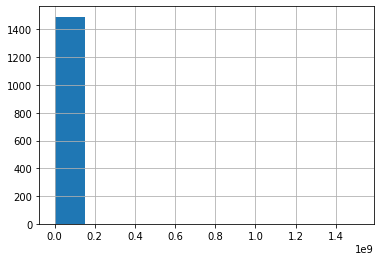

In [657]:
analyze(df['total_contract_sum_placer_supplier'])

### Среднее количество позиций в договоре для пары

unique: 60 empty: 0 filled: 1392, 
min: 1.0, mean: 1.629627039866869, max: 60.0, std: 2.6505464633720894


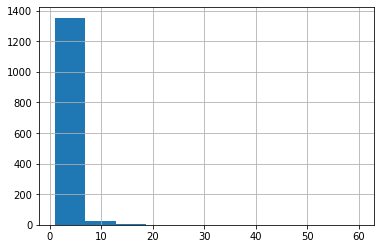

In [658]:
analyze(dataset['mean_contract_positions_placer_supplier'], categorical=False)

In [659]:
dataset[dataset['mean_contract_positions_placer_supplier'] > 10]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
60,745312780529,7447012841,0.207977,0.207977,427796.000,427796.00,37.0,37,0.333333,1.000000
95,3812132920,3805100204,0.000000,0.000000,402424.000,402424.00,16.0,16,1.000000,0.166667
103,2634059368,2633001291,0.000000,0.000000,239086.000,478172.00,13.0,13,0.500000,1.000000
127,6671152450,8905026850,0.000000,0.000000,5155560.000,5155560.00,11.0,11,0.142857,1.000000
177,7720263905,6629007354,0.000000,0.000000,8279637.350,8279637.35,12.0,12,0.125000,0.100000
424,7810520272,7806000721,0.006454,0.006454,489745.440,489745.44,16.0,16,0.250000,1.000000
1109,7721529234,3917000448,0.000000,0.000000,391590.480,391590.48,60.0,60,1.000000,1.000000
1215,2543146775,4909032631,0.000995,0.000995,272527.000,272527.00,12.0,12,0.166667,1.000000
1285,213008610767,2103003328,0.000000,0.000000,305903.920,305903.92,13.0,13,1.000000,1.000000
1390,7806514090,7812009592,0.018599,0.018599,201985.000,201985.00,16.0,16,0.333333,0.333333


In [660]:
dataset = dataset[dataset['mean_contract_positions_placer_supplier'] <= 10]

### Максимальное количество позиций в договоре для пары

unique: 16 empty: 0 filled: 1375, 
min: 1, mean: 1.5709090909090908, max: 34, std: 1.807077377683303


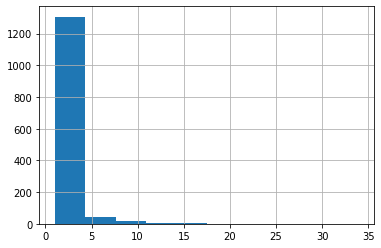

In [661]:
analyze(dataset['max_contract_positions_placer_supplier'], categorical=False)

### Процент договоров, которые заказчик заключил с этим поставщиком

unique: 126 empty: 0 filled: 1375, 
min: 0.0045662100456621, mean: 0.3879104386953756, max: 1.0, std: 0.3717099053939335


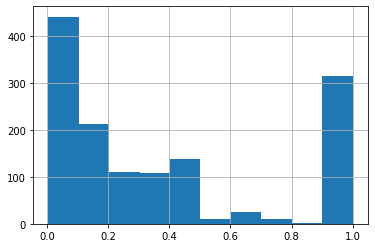

In [662]:
analyze(dataset['percent_placer_with_supplier_contracts'])

### Процент договоров, которые поставщик заключил с этим заказчиком

unique: 58 empty: 0 filled: 1375, 
min: 0.02040816326530612, mean: 0.8601132645132645, max: 1.0, std: 0.2810447450923777


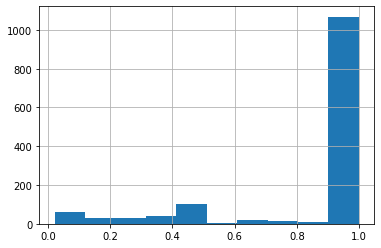

In [663]:
analyze(dataset['percent_supplier_with_placer_contracts'], categorical=False)

# 4. Стандартизируем признаки

In [664]:
data = dataset[calculated_features]
data = (data - data.mean()) / data.std()
data

,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,-0.222198,-0.492222,-0.355794,-0.371016,0.497738
1,-0.222198,-0.309297,0.166092,0.077362,-1.742580
2,-0.222198,-0.352619,-0.118573,-0.371016,0.497738
3,-0.222198,-0.254334,0.276795,1.232798,0.497738
4,-0.222198,-0.319212,-0.355794,-0.371016,0.497738
...,...,...,...,...,...
2667,-0.222198,-0.375818,-0.355794,-1.013356,0.497738
2668,-0.222198,-0.319111,-0.355794,1.646686,0.497738
2669,-0.222198,-0.560931,-0.355794,0.301551,0.497738
2670,-0.222198,0.001553,4.863066,1.646686,0.497738


In [665]:
dataset[calculated_features] = data
dataset

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,3460071768,3821005886,-0.222198,0.0,-0.492222,243570.00,-0.355794,1,-0.371016,0.497738
1,7704543951,3525147496,-0.222198,0.0,-0.309297,5145375.13,0.166092,3,0.077362,-1.742580
2,610601634808,6152000366,-0.222198,0.0,-0.352619,4954000.00,-0.118573,4,-0.371016,0.497738
3,6671095570,6623050480,-0.222198,0.0,-0.254334,6555490.00,0.276795,4,1.232798,0.497738
4,7726460307,7709125605,-0.222198,0.0,-0.319212,499850.00,-0.355794,1,-0.371016,0.497738
...,...,...,...,...,...,...,...,...,...,...
2667,7728024000,7224009059,-0.222198,0.0,-0.375818,416000.00,-0.355794,1,-1.013356,0.497738
2668,7705910160,7725009701,-0.222198,0.0,-0.319111,500000.00,-0.355794,1,1.646686,0.497738
2669,3019022395,3018010781,-0.222198,0.0,-0.560931,141792.00,-0.355794,1,0.301551,0.497738
2670,5321065111,7802312751,-0.222198,0.0,0.001553,974997.49,4.863066,7,1.646686,0.497738


# 5. Отбрасываем признаки, которые сильно коррелируют

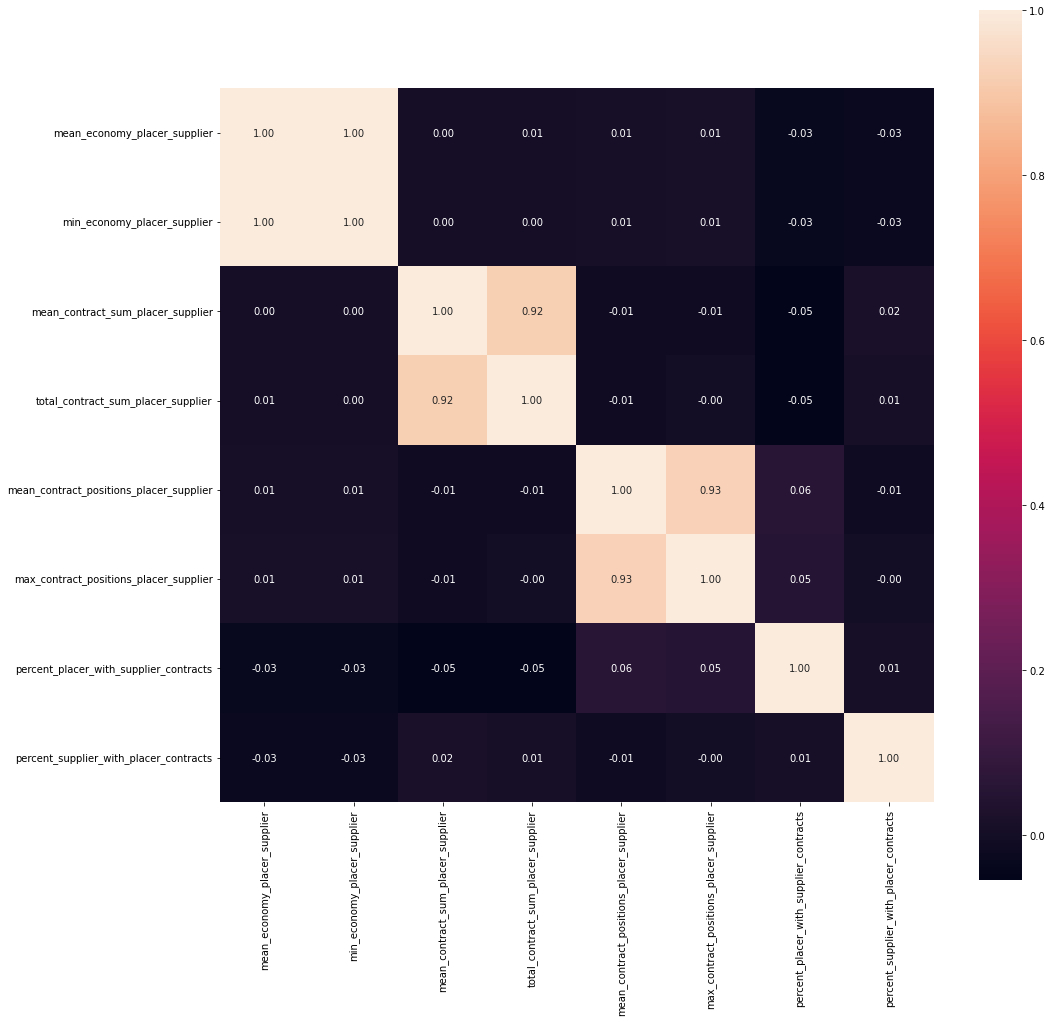

In [666]:
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(), annot=True, fmt='.2f', square=True)
plt.yticks(rotation='horizontal');

Видна корреляция между следующими признаками:

средняя экономия - минимальная экономия
средняя сумма - общая сумма
среднее количество позиций - максимальное количество позиций

In [667]:
columns = list(df.columns)
if 'min_economy_placer_supplier' in columns:
    columns.remove('min_economy_placer_supplier')
if 'total_contract_sum_placer_supplier' in columns:
    columns.remove('total_contract_sum_placer_supplier')
if 'max_contract_positions_placer_supplier' in columns:
    columns.remove('max_contract_positions_placer_supplier')
if 'min_economy_placer_supplier' in calculated_features:
    calculated_features.remove('min_economy_placer_supplier')
if 'total_contract_sum_placer_supplier' in calculated_features:
    calculated_features.remove('total_contract_sum_placer_supplier')
if 'max_contract_positions_placer_supplier' in calculated_features:
    calculated_features.remove('max_contract_positions_placer_supplier')
dataset = dataset[columns]
dataset

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,3460071768,3821005886,-0.222198,-0.492222,-0.355794,-0.371016,0.497738
1,7704543951,3525147496,-0.222198,-0.309297,0.166092,0.077362,-1.742580
2,610601634808,6152000366,-0.222198,-0.352619,-0.118573,-0.371016,0.497738
3,6671095570,6623050480,-0.222198,-0.254334,0.276795,1.232798,0.497738
4,7726460307,7709125605,-0.222198,-0.319212,-0.355794,-0.371016,0.497738
...,...,...,...,...,...,...,...
2667,7728024000,7224009059,-0.222198,-0.375818,-0.355794,-1.013356,0.497738
2668,7705910160,7725009701,-0.222198,-0.319111,-0.355794,1.646686,0.497738
2669,3019022395,3018010781,-0.222198,-0.560931,-0.355794,0.301551,0.497738
2670,5321065111,7802312751,-0.222198,0.001553,4.863066,1.646686,0.497738


# 6. Кластеризация

In [668]:
import scipy.cluster as clst

In [669]:
data = dataset[calculated_features]
data

,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,-0.222198,-0.492222,-0.355794,-0.371016,0.497738
1,-0.222198,-0.309297,0.166092,0.077362,-1.742580
2,-0.222198,-0.352619,-0.118573,-0.371016,0.497738
3,-0.222198,-0.254334,0.276795,1.232798,0.497738
4,-0.222198,-0.319212,-0.355794,-0.371016,0.497738
...,...,...,...,...,...
2667,-0.222198,-0.375818,-0.355794,-1.013356,0.497738
2668,-0.222198,-0.319111,-0.355794,1.646686,0.497738
2669,-0.222198,-0.560931,-0.355794,0.301551,0.497738
2670,-0.222198,0.001553,4.863066,1.646686,0.497738


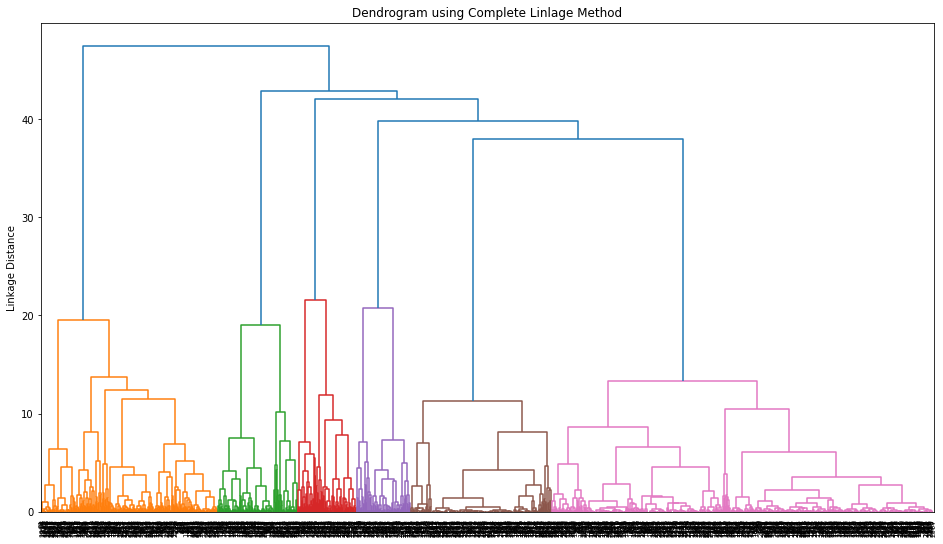

In [697]:
Z = clst.hierarchy.linkage(data, method='ward')
plt.figure(figsize=(16, 9))
dn = clst.hierarchy.dendrogram(Z, labels=data.index)
plt.xticks(rotation='vertical', fontsize=7);
plt.title('Dendrogram using Complete Linlage Method');
plt.ylabel('Linkage Distance');

In [704]:
from sklearn.cluster import AgglomerativeClustering

# Указать количество кластеров в параметре n_clusters
clust = AgglomerativeClustering(n_clusters=6, linkage='ward', affinity='euclidean')
dataset['cluster'] = clust.fit_predict(data)
dataset['cluster'].value_counts()

/tmp/ipykernel_6301/1672177548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cluster'] = clust.fit_predict(data)


4    588
3    273
5    217
2    122
0     91
1     84
Name: cluster, dtype: int64

In [705]:
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=6)
dataset['cluster'] = clust.fit_predict(data)
dataset['cluster'].value_counts()

/tmp/ipykernel_6301/1666049322.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cluster'] = clust.fit_predict(data)


2    671
5    273
1    219
3     92
0     66
4     54
Name: cluster, dtype: int64

In [706]:
# Сводная таблица средних значений по кластерам
pivot_table = dataset.groupby('cluster')[calculated_features].mean()
pivot_table

,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
cluster,,,,,
0,-0.131158,-0.245213,3.740263,0.214229,0.113246
1,-0.123891,-0.173896,-0.121230,-0.191123,-2.034309
2,-0.215527,-0.218197,-0.203789,-0.535145,0.460865
3,-0.062997,3.046687,-0.285673,-0.372368,0.287693
4,4.226045,0.083139,-0.093021,-0.035591,0.204520
5,-0.153860,-0.308085,-0.191430,1.549374,0.334385


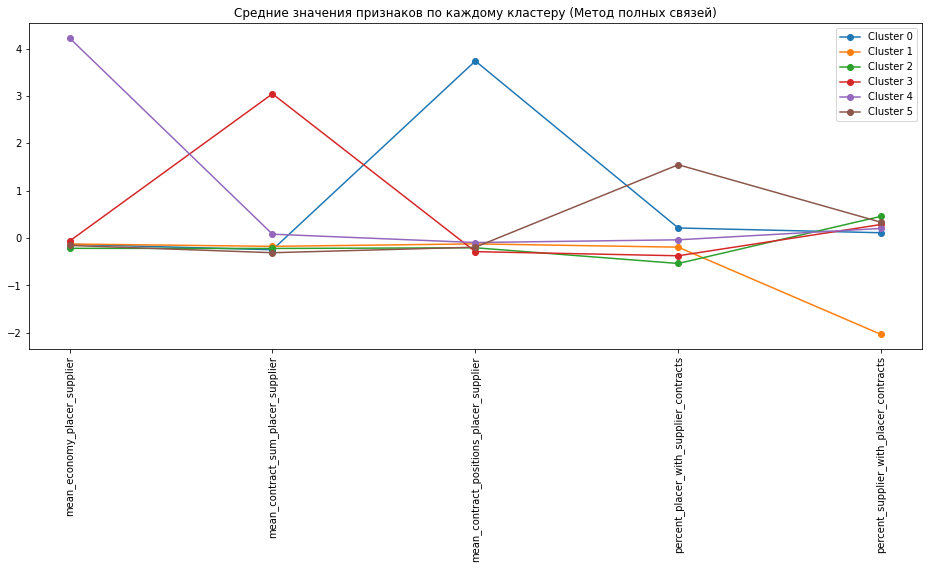

In [707]:
# Графики средних значений по кластерам

plt.figure(figsize=(16, 6))

for cluster in pivot_table.T.columns:
    plt.plot(pivot_table.T[cluster], 'o-', label=f'Cluster {cluster}')
plt.xticks(rotation='vertical')
plt.title('Средние значения признаков по каждому кластеру (Метод полных связей)')
plt.legend();

In [708]:
dataset[dataset['cluster'] == 2]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts,cluster
0,3460071768,3821005886,-0.222198,-0.492222,-0.355794,-0.371016,0.497738,2
2,610601634808,6152000366,-0.222198,-0.352619,-0.118573,-0.371016,0.497738,2
4,7726460307,7709125605,-0.222198,-0.319212,-0.355794,-0.371016,0.497738,2
5,2308185326,2312210286,-0.222198,-0.471984,-0.355794,0.032524,0.497738,2
10,7728458261,3325008103,-0.222198,0.181296,-0.355794,-0.684881,0.497738,2
...,...,...,...,...,...,...,...,...
2657,9901004600,7743254939,-0.222198,-0.431175,-0.355794,-0.819395,0.497738,2
2663,503505318740,7712038455,-0.222198,-0.377168,-0.355794,-0.885333,0.497738,2
2667,7728024000,7224009059,-0.222198,-0.375818,-0.355794,-1.013356,0.497738,2
2669,3019022395,3018010781,-0.222198,-0.560931,-0.355794,0.301551,0.497738,2


# 7. Анализ путем прямого сравнения со средними

In [675]:
direct = df
direct

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,3460071768,3821005886,0.0,0.0,2.435700e+05,243570.00,1.000000,1,0.250000,1.00000
1,7704543951,3525147496,0.0,0.0,5.145375e+05,5145375.13,1.600000,3,0.416667,0.37037
2,610601634808,6152000366,0.0,0.0,4.503636e+05,4954000.00,1.272727,4,0.250000,1.00000
3,6671095570,6623050480,0.0,0.0,5.959536e+05,6555490.00,1.727273,4,0.846154,1.00000
4,7726460307,7709125605,0.0,0.0,4.998500e+05,499850.00,1.000000,1,0.250000,1.00000
...,...,...,...,...,...,...,...,...,...,...
2667,7728024000,7224009059,0.0,0.0,4.160000e+05,416000.00,1.000000,1,0.011236,1.00000
2668,7705910160,7725009701,0.0,0.0,5.000000e+05,500000.00,1.000000,1,1.000000,1.00000
2669,3019022395,3018010781,0.0,0.0,1.417920e+05,141792.00,1.000000,1,0.500000,1.00000
2670,5321065111,7802312751,0.0,0.0,9.749975e+05,974997.49,7.000000,7,1.000000,1.00000


### Удалим выборсы

unique: 314 empty: 0 filled: 1498, 
min: -86.06770029673591, mean: -0.24859546884226294, max: 0.872799, std: 4.649876909149694


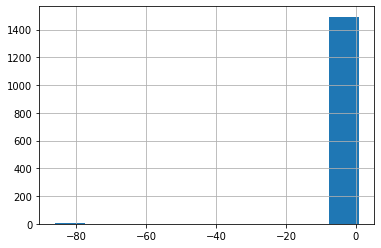

In [676]:
analyze(direct['mean_economy_placer_supplier'])

In [677]:
direct[direct['mean_economy_placer_supplier'] < -1]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
410,7715986384,7705709543,-85.409200,-85.409200,636408.94,636408.94,1.0,1,0.166667,1.000000
448,7842002467,2709001590,-73.357691,-73.357691,658189.74,658189.74,2.0,2,0.500000,1.000000
519,7726625380,4214000252,-85.250000,-85.250000,1463158.80,1463158.80,1.0,1,0.333333,1.000000
1033,7203474440,7204006910,-2.250000,-2.250000,2099500.00,2099500.00,1.0,1,0.090909,0.111111
2051,7717742545,1435275203,-71.229999,-71.229999,147908.98,147908.98,1.0,1,1.000000,1.000000
2107,2312118918,2308082850,-86.067700,-86.067700,1349723.49,1349723.49,1.0,1,1.000000,1.000000
2264,7710641442,7701024933,-2.000000,-2.000000,3069000.00,3069000.00,1.0,1,1.000000,1.000000


In [678]:
direct = direct[direct['mean_economy_placer_supplier'] >= -1]

### Подсчёт средних

In [679]:
mean_economy_mean = direct['mean_economy_placer_supplier'].mean()
mean_economy_mean

0.02224585989223811

In [680]:
min_economy_mean = direct['min_economy_placer_supplier'].mean()
min_economy_mean

0.013401146891834264

In [681]:
mean_contract_sum_mean = direct['mean_contract_sum_placer_supplier'].mean()
mean_contract_sum_mean

3412724.2010589736

In [682]:
total_contract_sum_mean = df['total_contract_sum_placer_supplier'].mean()
total_contract_sum_mean

5584591.4753004005

In [683]:
mean_contract_positions_mean = direct['mean_contract_positions_placer_supplier'].mean()
mean_contract_positions_mean

1.624820594340274

In [684]:
max_contract_positions_mean = direct['max_contract_positions_placer_supplier'].mean()
max_contract_positions_mean

1.78336686787391

In [685]:
percent_placer_with_supplier_mean = direct['percent_placer_with_supplier_contracts'].mean()
percent_placer_with_supplier_mean

0.3896103896103897

In [686]:
percent_supplier_with_placer_mean = direct['percent_supplier_with_placer_contracts'].mean()
percent_supplier_with_placer_mean

0.8617631716223264

In [696]:
direct[
    (direct['mean_economy_placer_supplier'] < mean_economy_mean)
    & (direct['min_economy_placer_supplier'] < min_economy_mean)
    & (direct['mean_contract_sum_placer_supplier'] > mean_contract_sum_mean)
    # & (direct['total_contract_sum_placer_supplier'] > total_contract_sum_mean)
    & (direct['mean_contract_positions_placer_supplier'] > mean_contract_positions_mean)
    & (direct['max_contract_positions_placer_supplier'] > max_contract_positions_mean)
    # & (direct['percent_supplier_with_placer_contracts'] > percent_supplier_with_placer_mean)
    & (direct['percent_placer_with_supplier_contracts'] > percent_placer_with_supplier_mean)
    ]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
676,7713053544,901021165,-6.666667e-01,-1.000000e+00,3.996667e+06,11990000.0,1.666667,2,1.0,0.230769
970,7801333565,7706019535,6.258223e-09,6.258223e-09,3.994744e+07,39947444.4,7.000000,7,1.0,1.000000
1262,105031454,2304030699,8.121587e-03,8.121587e-03,3.941580e+06,3941580.0,8.000000,8,1.0,1.000000
2315,2466137702,2466189073,0.000000e+00,0.000000e+00,4.478900e+06,4478900.0,2.000000,2,1.0,1.000000
